In [ ]:
import numpy as np
import  json
from  shapely.geometry  import Polygon, Point
import shapely.ops as shops
#from descartes.patch import PolygonPatch
import shapely.vectorized
from datetime import datetime
import matplotlib.pyplot as plt
import xarray as xr
import hvplot.xarray
import pandas as pd
from IPython.display import display, HTML
from scipy import interpolate, signal
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
%matplotlib inline

titles = ([\
         "22-Jan-2016",\
         "25-Jan-2016",\
         "11-Feb-2016",\
         "30-Mar-2016",\
         "21-Sep-2016",\
         "09-Jan-2017",\
         "25-Jan-2017",\
         "14-Feb-2017",\
         "16-Mar-2017",\
         "28-Apr-2017",\
         "04-May-2017",\
         "18-Sep-2017",\
#         "03-Jan-2017",\
         "10-Jan-2018",\
         "09-Mar-2018"]
         )
da = xr.open_dataarray('one_meter_test.nc')
(num_maps,ysize,xsize)=np.shape(da.values)
print('Shape of stacked elevation array: ',num_maps,xsize,ysize)

# use meshgrid to make coordinate arrays
X, Y = np.meshgrid( da.coords['Cross-shore'].values, da.coords['Alongshore'].values )
print('Shape of X and Y',np.shape(X),np.shape(Y))
da

# grab one DEM to experiment with
elev = np.array(np.squeeze(da[0,:,:].copy()))

In [62]:
eda = da[0,:,:].where(da[0,:,:]>=-1.,np.NaN)

IndexError: list index out of range

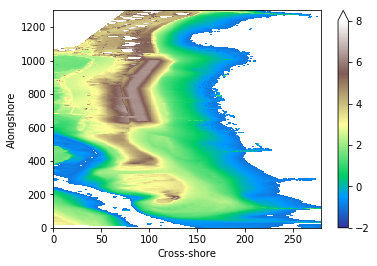

In [88]:
a=eda.plot(vmin=-2,vmax=8,cmap=plt.cm.terrain )
ax=plt.gca()        #plt.gca() for current axis, otherwise set appropriately.
im=ax.images        #this is a list of all images that have been plotted
im[0]
# cb=im.colorbar
# cb.remove()

In [84]:
dir(im)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'clear',
 'copy',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

In [73]:
a.colorbar=None

C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\IOOS3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  


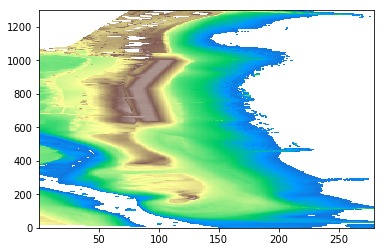

In [63]:
# this test won't work on a data array, so I converted it to a np array above
elev[elev<=-1.]=np.NaN
plt.pcolormesh(X, Y, eda, vmin=-2,vmax=8,cmap=plt.cm.terrain )

In [9]:
dydz, dxdz = np.gradient(elev)
slope_mag = np.sqrt(dxdz**2 + dydz**2)
slope = np.pi/2. - np.arctan(slope_mag)
aspect = np.rad2deg( np.arctan2(-dxdz, dydz) )

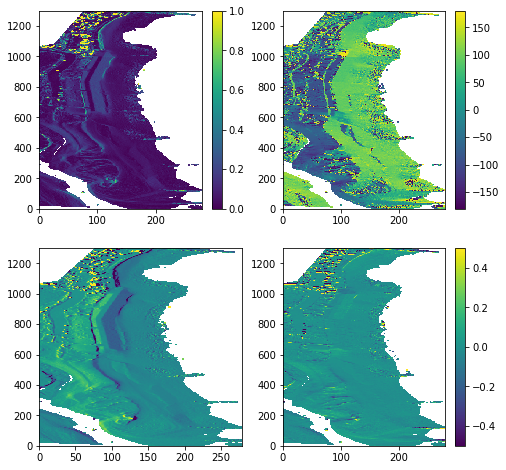

In [10]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(221)
plt.pcolormesh(X,Y,slope_mag,vmin=0,vmax=1.)
plt.colorbar()
ax = fig.add_subplot(222)
plt.pcolormesh(X,Y,aspect,vmin=-180.,vmax=180.)
plt.colorbar()
ax = fig.add_subplot(223)
plt.pcolormesh(X,Y,dxdz,vmin=-.5,vmax=+.5)
ax = fig.add_subplot(224)
plt.pcolormesh(X,Y,dydz,vmin=-.5,vmax=+.5)
plt.colorbar()

In [7]:
np.rad2deg(aspect)

array([[          nan,           nan,           nan, ...,   80.47837324,
         114.24580767,   46.80125926],
       [          nan,           nan,           nan, ...,   94.51119664,
          76.2853243 ,  -55.01280797],
       [          nan,           nan,           nan, ...,  108.70966772,
          52.85873362,  104.61227428],
       ..., 
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])

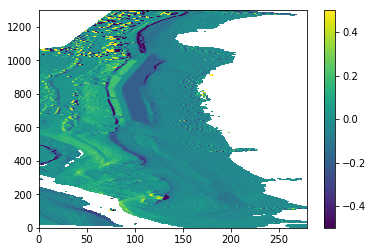

In [26]:
plt.pcolormesh(X,Y,dxdz,vmin=-.5,vmax=+.5)
plt.colorbar()

In [16]:
def hillshade(array, az, alt):
    # Modified after http://geoexamples.blogspot.com.br/2014/03/shaded-relief-images-using-gdal-python.html
    azr = np.deg2rad(360.-az)
    altr = np.deg2rad(alt)

    y,x = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    
    shaded = np.sin(altr) * np.sin(slope) \
     + np.cos( altr ) * np.cos(slope) \
     * np.cos(azr - aspect)
    return 255*(shaded + 1)/2

In [25]:
print(X[1:4,1:4])
print(Y[1:4,1:4])

[[ 1.5  2.5  3.5]
 [ 1.5  2.5  3.5]
 [ 1.5  2.5  3.5]]
[[ 1.5  1.5  1.5]
 [ 2.5  2.5  2.5]
 [ 3.5  3.5  3.5]]


In [90]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(a)
i = 1
j = 1
print(a[i-1,j-1])

[[1 2 3]
 [4 5 6]
 [7 8 9]]
1


In [94]:
from operator import add

def slope_aspect(a,d=1.):
    i=1
    j=1
    Z1=a[i+1,j-1]
    Z2=a[i+1,j]
    Z3=a[i+1,j+1]
    Z4=a[i,j-1]
    Z5=a[i,j]
    Z6=a[i,j+1]
    Z7=a[i-1,j-1]
    Z8=a[i-1,j]
    Z9=a[i-1,j+1]
    print(Z1,Z2,Z3)
    print(Z4,Z5,Z6)
    print(Z7,Z8,Z9)
    
    A = ((Z1 + Z3 + Z7 + Z9)/4. - (Z2 + Z4 + Z6 + Z8)/2. + Z5)/d**4
    B = ((Z1 + Z3 - Z7 - Z9)/4. - (Z2 - Z8)/2.)/d**3
    C = ((-Z1 + Z3 - Z7 + Z9)/4. + (Z4 - Z6)/2.)/d**3
    D = ((Z4 + Z6)/2. - Z5)/d**2
    E = ((Z2 + Z8)/2. - Z5)/d**2
    F = (-Z1 + Z3 + Z7 - Z9)/(4.*d**2)
    G = (-Z4 + Z6)/(2.*d)
    H = (Z2 - Z8)/(2.*d)
    I = Z5
    
    slope = np.sqrt(G**2 + H**2)
    aspect = np.arctan2(-H, -G)
    PrC =  2.*(D*G**2 + E*H**2 + F*G*H)/(G**2 + H**2)
    PlC = -2.*(D*H**2 + E*G**2 - F*G*H)/(G**2 + H**2)
    print(slope,aspect,PrC,PlC)

a = np.array([[1,2,3],[4,5,6],[7,8,9]])
slope_aspect(a)
    

7 8 9
4 5 6
1 2 3
3.16227766017 -1.89254688119 0.0 -0.0


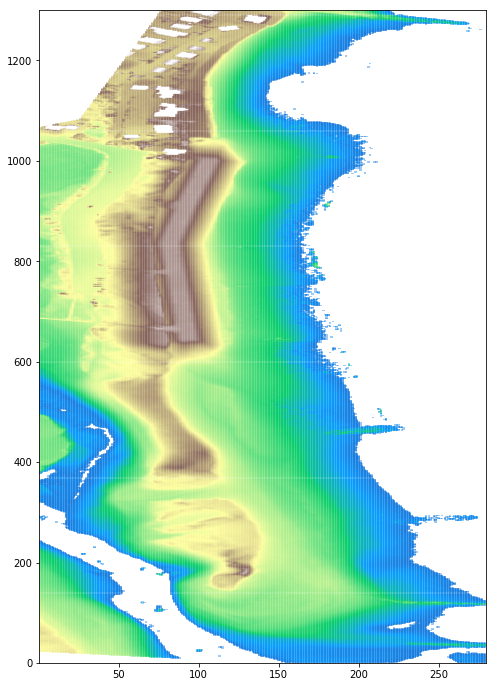

In [59]:
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111)
#plt.pcolormesh(X, Y, hillshade(elev, 330.,0.),cmap='Greys', alpha=.5)
plt.pcolormesh(X, Y, elev, vmin=-2,vmax=8,cmap=plt.cm.terrain, alpha=.4 )

#cax = ax.contourf(elev, np.arange(-2, 8, 10), 
#cmap=plt.cm.terrain, vmin=-2., vmax=8., origin='image')
#fig.colorbar(cax, ax=ax)
#fig.savefig('shaded_topo.png')